In [2]:
from easydict import EasyDict as ed
import os
import mindspore.common.dtype as mstype
import mindspore.dataset.engine as de

import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2
import numpy as np

参数设置

In [3]:
config = ed({
    "class_num": 10,  # 分组10个。
    "batch_size": 32,# 分组大小 32.
    "loss_scale": 1024,#loss_scale是分
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "epoch_size": 90,
    "buffer_size": 100,
    "image_height": 224,
    "image_width": 224,
    "save_checkpoint": True,
    "save_checkpoint_steps": 195,
    "keep_checkpoint_max": 10,
    "save_checkpoint_path": "./",
    "lr_init": 0.01,
    "lr_end": 0.00001,
    "lr_max": 0.1,
    "warmup_epochs": 5,
    "lr_decay_mode": "poly"
})

动态学习率

In [4]:

def get_lr(global_step, lr_init, lr_end, lr_max, warmup_epochs, total_epochs, steps_per_epoch, lr_decay_mode):
    """
    generate learning rate array

    Args:
       global_step(int): total steps of the training
       lr_init(float): init learning rate
       lr_end(float): end learning rate
       lr_max(float): max learning rate
       warmup_epochs(int): number of warmup epochs
       total_epochs(int): total epoch of training
       steps_per_epoch(int): steps of one epoch
       lr_decay_mode(string): learning rate decay mode, including steps, poly or default

    Returns:
       np.array, learning rate array
    """
    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    warmup_steps = steps_per_epoch * warmup_epochs
    if lr_decay_mode == 'steps':
        decay_epoch_index = [0.3 * total_steps, 0.6 * total_steps, 0.8 * total_steps]
        for i in range(total_steps):
            if i < decay_epoch_index[0]:
                lr = lr_max
            elif i < decay_epoch_index[1]:
                lr = lr_max * 0.1
            elif i < decay_epoch_index[2]:
                lr = lr_max * 0.01
            else:
                lr = lr_max * 0.001
            lr_each_step.append(lr)
    elif lr_decay_mode == 'poly':
        if warmup_steps != 0:
            inc_each_step = (float(lr_max) - float(lr_init)) / float(warmup_steps)
        else:
            inc_each_step = 0
        for i in range(total_steps):
            if i < warmup_steps:
                lr = float(lr_init) + inc_each_step * float(i)
            else:
                base = (1.0 - (float(i) - float(warmup_steps)) / (float(total_steps) - float(warmup_steps)))
                lr = float(lr_max) * base * base
                if lr < 0.0:
                    lr = 0.0
            lr_each_step.append(lr)
    else:
        for i in range(total_steps):
            if i < warmup_steps:
                lr = lr_init + (lr_max - lr_init) * i / warmup_steps
            else:
                lr = lr_max - (lr_max - lr_end) * (i - warmup_steps) / (total_steps - warmup_steps)
            lr_each_step.append(lr)

    current_step = global_step
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    learning_rate = lr_each_step[current_step:]

    return learning_rate


网络定义

In [5]:
import numpy as np
import mindspore.nn as nn
from mindspore.ops import operations as P
from mindspore.common.tensor import Tensor

In [6]:
def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)


def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)


def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)


def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)


class ResidualBlock(nn.Cell):
    """
    ResNet V1 residual block definition.

    Args:
        in_channel (int): Input channel.
        out_channel (int): Output channel.
        stride (int): Stride size for the first convolutional layer. Default: 1.

    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResidualBlock(3, 256, stride=2)
    """
    expansion = 4

    def __init__(self,
                 in_channel,
                 out_channel,
                 stride=1):
        super(ResidualBlock, self).__init__()

        channel = out_channel // self.expansion
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)

        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)

        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)

        self.relu = nn.ReLU()

        self.down_sample = False

        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None

        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride),
                                                        _bn(out_channel)])
        self.add = P.TensorAdd()

    def construct(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.down_sample:
            identity = self.down_sample_layer(identity)

        out = self.add(out, identity)
        out = self.relu(out)

        return out


class ResNet(nn.Cell):
    """
    ResNet architecture.

    Args:
        block (Cell): Block for network.
        layer_nums (list): Numbers of block in different layers.
        in_channels (list): Input channel in each layer.
        out_channels (list): Output channel in each layer.
        strides (list):  Stride size in each layer.
        num_classes (int): The number of classes that the training images are belonging to.
    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResNet(ResidualBlock,
        >>>        [3, 4, 6, 3],
        >>>        [64, 256, 512, 1024],
        >>>        [256, 512, 1024, 2048],
        >>>        [1, 2, 2, 2],
        >>>        10)
    """

    def __init__(self,
                 block,
                 layer_nums,
                 in_channels,
                 out_channels,
                 strides,
                 num_classes):
        super(ResNet, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")

        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = P.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=strides[0])
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=strides[1])
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=strides[2])
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=strides[3])

        self.mean = P.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.end_point = _fc(out_channels[3], num_classes)

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        """
        Make stage network of ResNet.

        Args:
            block (Cell): Resnet block.
            layer_num (int): Layer number.
            in_channel (int): Input channel.
            out_channel (int): Output channel.
            stride (int): Stride size for the first convolutional layer.

        Returns:
            SequentialCell, the output layer.

        Examples:
            >>> _make_layer(ResidualBlock, 3, 128, 256, 2)
        """
        layers = []

        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)

        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)

        return nn.SequentialCell(layers)

    def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        out = self.mean(c5, (2, 3))
        out = self.flatten(out)
        out = self.end_point(out)

        return out


def resnet50(class_num=10):
    """
    Get ResNet50 neural network.

    Args:
        class_num (int): Class number.

    Returns:
        Cell, cell instance of ResNet50 neural network.

    Examples:
        >>> net = resnet50(10)
    """
    return ResNet(ResidualBlock,
                  [3, 4, 6, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num)

def resnet101(class_num=1001):
    """
    Get ResNet101 neural network.

    Args:
        class_num (int): Class number.

    Returns:
        Cell, cell instance of ResNet101 neural network.

    Examples:
        >>> net = resnet101(1001)
    """
    return ResNet(ResidualBlock,
                  [3, 4, 23, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num)


In [7]:
import os
import random
import argparse
import mindspore.nn as nn
import mindspore.common.dtype as mstype
import mindspore.ops.functional as F
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits
from mindspore.communication.management import init
from mindspore import Tensor
from mindspore.ops import operations as P
from mindspore.nn.optim.momentum import Momentum
from mindspore.train.model import Model, ParallelMode
from mindspore import context
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.parallel._auto_parallel_context import auto_parallel_context

In [8]:
random.seed(1)

In [9]:
parser = argparse.ArgumentParser(description='Image classification')
parser.add_argument('--do_train', type=bool, default=True, help='Do train or not.')
parser.add_argument('--do_eval', type=bool, default=False, help='Do eval or not.')

_StoreAction(option_strings=['--do_eval'], dest='do_eval', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, help='Do eval or not.', metavar=None)

In [10]:
parser.add_argument('--epoch_size', type=int, default=10, help='Epoch size.')
parser.add_argument('--batch_size', type=int, default=32, help='Batch size.')
parser.add_argument('--num_classes', type=int, default=10, help='Num classes.')

_StoreAction(option_strings=['--num_classes'], dest='num_classes', nargs=None, const=None, default=10, type=<class 'int'>, choices=None, help='Num classes.', metavar=None)

In [11]:
parser.add_argument('--data_urt', type=str, default='/cache/data', help='Dataset path')

_StoreAction(option_strings=['--data_urt'], dest='data_urt', nargs=None, const=None, default='/cache/data', type=<class 'str'>, choices=None, help='Dataset path', metavar=None)

In [12]:
parser.add_argument('--checkpoint_path', type=str, default='ckpt', help='CheckPoint file path.')
parser.add_argument('--dataset_path', type=str, default='cifar10_data', help='Dataset path.')

_StoreAction(option_strings=['--dataset_path'], dest='dataset_path', nargs=None, const=None, default='cifar10_data', type=<class 'str'>, choices=None, help='Dataset path.', metavar=None)

In [13]:
args_opt = parser.parse_known_args()[0]

In [14]:
device_target = context.get_context('device_target') # 获取运行装置（CPU，GPU，Ascend）

dataset_sink_mode = True if device_target in ['Ascend','GPU'] else False # 是否将数据通过pipeline下发到装置上

context.set_context(mode = context.GRAPH_MODE, device_target = device_target) 

数据处理

In [15]:
def create_dataset(data_path,repeat_num=1, training=True,batch_size=args_opt.batch_size):
    """
    create data for next use such as training or infering
    """
    cifar_ds = ds.Cifar10Dataset(data_path)

    cifar_ds = ds.Cifar10Dataset(data_path)

    resize_height = 224
    resize_width = 224
    rescale = 1.0 / 255.0
    shift = 0.0

    # 数据增强
    random_crop_op = C.RandomCrop((32, 32), (4, 4, 4, 4)) # 随机裁剪
    random_horizontal_op = C.RandomHorizontalFlip() # 随机翻转
    resize_op = C.Resize((resize_height, resize_width)) # 重定义大小
    rescale_op = C.Rescale(rescale, shift)
    normalize_op = C.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    changeswap_op = C.HWC2CHW()
    type_cast_op = C2.TypeCast(mstype.int32)

    c_trans = []
    if training:
        c_trans = [random_crop_op, random_horizontal_op]
    c_trans += [resize_op, rescale_op, normalize_op,
                changeswap_op]

    
    cifar_ds = cifar_ds.map(input_columns="label", operations=type_cast_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=c_trans)

    # shuffle 
    cifar_ds = cifar_ds.shuffle(buffer_size=10)

    # batch 
    cifar_ds = cifar_ds.batch(batch_size=batch_size, drop_remainder=True)

    # repeat 
    cifar_ds = cifar_ds.repeat(repeat_num)

    return cifar_ds


模型训练

In [14]:
if __name__ == '__main__':

    epoch_size = args_opt.epoch_size
    batch_size = args_opt.batch_size
    net = resnet50(class_num=args_opt.num_classes)
    ls = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
    opt = Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.01, 0.9)

    model = Model(net, loss_fn=ls, optimizer=opt, metrics={'acc'})
    # args_opt.do_train=False
    # 模型训练
    if args_opt.do_train:
        dataset = create_dataset('cifar-10-batches-bin',epoch_size)
        batch_num = dataset.get_dataset_size()
        config_ck = CheckpointConfig(save_checkpoint_steps=batch_num, keep_checkpoint_max=35)
        ckpoint_cb = ModelCheckpoint(prefix="train_resnet_cifar10", directory="./", config=config_ck)
        loss_cb = LossMonitor()
        model.train(epoch_size, dataset, callbacks=[ckpoint_cb, loss_cb])

[WARNING] ME(25179:139713829921728,MainProcess):2022-05-31-00:43:13.136.731 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(25179:139713829921728,MainProcess):2022-05-31-00:43:13.151.410 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(25179:139713829921728,MainProcess):2022-05-31-00:43:13.166.053 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(25179:139713829921728,MainProcess):2022-05-31-00:43:13.198.970 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(25179:139713829921728,MainProcess):2022-05-31-00:43:13.222.660 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated fr

epoch: 1 step: 15620, loss is 0.5356441
epoch: 2 step: 15620, loss is 0.37862647
epoch: 3 step: 15620, loss is 0.058988493
epoch: 4 step: 15620, loss is 0.07905386
epoch: 5 step: 15620, loss is 0.06946219
epoch: 6 step: 15620, loss is 0.03425297
epoch: 7 step: 15620, loss is 0.033489935
epoch: 8 step: 15620, loss is 0.0008537335
epoch: 9 step: 15620, loss is 0.0022543888
epoch: 10 step: 15620, loss is 0.0036945343


模型评估

In [21]:
# as for evaluation, users could use model.eval
epoch_size = args_opt.epoch_size
batch_size = args_opt.batch_size
net = resnet50(class_num=args_opt.num_classes)
ls = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
opt = Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.01, 0.9)

model = Model(net, loss_fn=ls, optimizer=opt, metrics={'acc'})
param_dict = load_checkpoint('train_resnet_cifar10-10_15620.ckpt')
load_param_into_net(net, param_dict)
eval_dataset = create_dataset('cifar-10-verify-bin',1, training=False)
res = model.eval(eval_dataset)
print("result: ", res)

[WARNING] ME(1896:139718557373376,MainProcess):2022-05-31-12:23:19.295.789 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(1896:139718557373376,MainProcess):2022-05-31-12:23:19.310.815 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(1896:139718557373376,MainProcess):2022-05-31-12:23:19.325.534 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(1896:139718557373376,MainProcess):2022-05-31-12:23:19.357.938 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(1896:139718557373376,MainProcess):2022-05-31-12:23:19.382.219 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from ve

result:  {'acc': 0.9181690705128205}


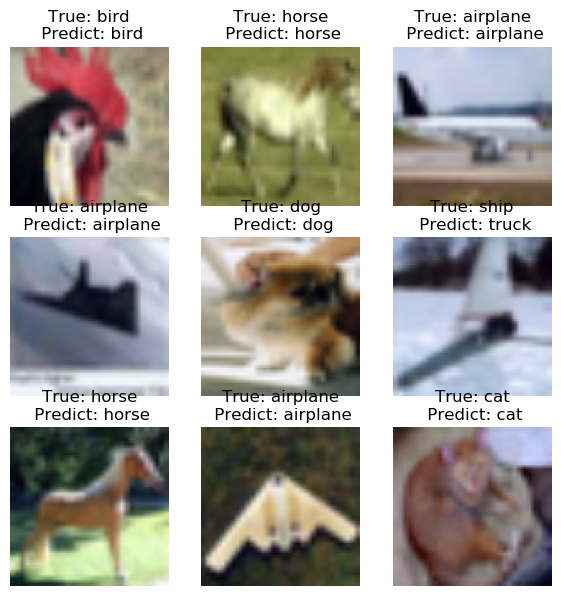

In [18]:
#创建图像标签列表
import matplotlib.pyplot as plt
category_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',
6:'frog',7:'horse',8:'ship',9:'truck'}
data_path=os.path.join('data', '10-verify-bin')
demo_data = create_dataset('cifar-10-verify-bin',1, training=False,batch_size=1)
# 将数据标准化至0~1区间
def normalize(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
# 设置图像大小
plt.figure(figsize=(7,7))
i = 1
# 打印9张子图
for dic in demo_data.create_dict_iterator():
# 预测单张图片
    input_img = dic['image']
    output = model.predict(input_img)
    predict = np.argmax(output.asnumpy(),axis=1)[0] # 反馈可能性最大的类别
# 可视化
    plt.subplot(3,3,i)
    input_image = np.squeeze(input_img.asnumpy(),axis=0) # 删除batch维度，方便可视化
    input_image = input_image.transpose(1,2,0) # CHW转HWC，方便可视化
    input_image = normalize(input_image) # 重新标准化，方便可视化
    plt.imshow(input_image)
    plt.axis('off')
    plt.title('True: %s\n Predict: %s'%(category_dict[dic['label'].asnumpy().item()],category_dict[predict]))
    i +=1
    if i > 9 :
        break
plt.show()